# ==========================================================
# MSCS 634 - Advanced Big Data Mining
# Project Deliverable 3
# Professor - Dr. Satish Penmatsa
# ==========================================================

# Team Members
# Prashanna Acharya, Bikash Shrestha, Bibek Itani, Ujjwal Khadka, Abhishek Pandey, Sahil Rauniyar

# 1. Importing Libraries

In [9]:
import pandas as pd
import numpy as np


try:
    df = pd.read_csv('healthcare-dataset-stroke-data.csv')
    print("Loaded RAW dataset.")
except FileNotFoundError:
    print("ERROR: Could not find 'healthcare-dataset-stroke-data.csv'. Please upload the original raw file.")
    df = pd.read_csv('cleaned_stroke_data.csv') 


print("Class Distribution (Target: Stroke):")
print(df['stroke'].value_counts())

df['bmi'] = df['bmi'].fillna(df['bmi'].median())


if 'id' in df.columns:
    df = df.drop(columns=['id'])


df = df[df['gender'] != 'Other']

print(f"\nFinal Shape: {df.shape}")
print(f"Stroke cases remaining: {df['stroke'].sum()}")


from sklearn.model_selection import train_test_split

X = df.drop(columns=['stroke'])
y = df['stroke']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Loaded RAW dataset.
Class Distribution (Target: Stroke):
stroke
0    4861
1     249
Name: count, dtype: int64

Final Shape: (5109, 11)
Stroke cases remaining: 249


# Classification

Tuning Decision Tree (this may take a moment)...
Best Decision Tree Params: {'classifier__criterion': 'entropy', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 10}

--- Classification Metrics (Test Set) ---
Tuned Decision Tree -> Accuracy: 0.5675, F1: 0.1597
k-NN               -> Accuracy: 0.9501, F1: 0.0000

--- Decision Tree Classification Report ---
              precision    recall  f1-score   support

           0       0.99      0.55      0.71       972
           1       0.09      0.84      0.16        50

    accuracy                           0.57      1022
   macro avg       0.54      0.70      0.43      1022
weighted avg       0.94      0.57      0.68      1022


--- k-NN Classification Report ---
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      10

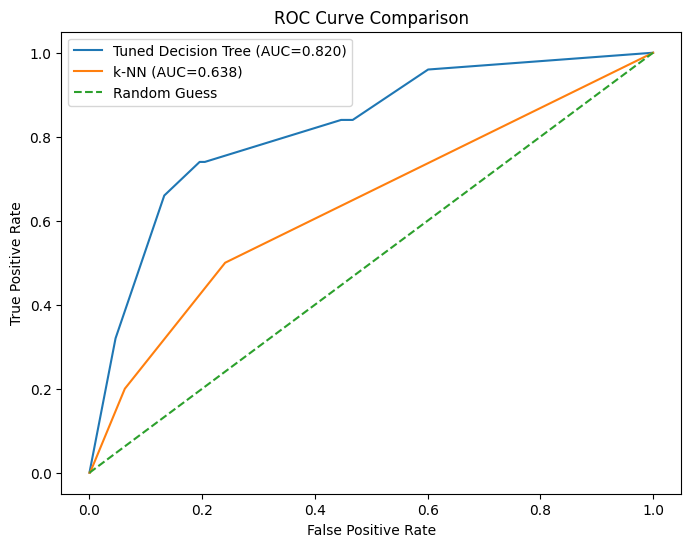

,Model,Accuracy,F1,ROC AUC
0,Tuned Decision Tree,0.567515,0.159696,0.820381
1,k-NN,0.950098,0.000000,0.637912


In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Identifying numeric and categorical columns

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Numeric pipeline: imputing and scaling

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: imputing and one-hot encoding

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Full preprocessing

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])


dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))])

# Hyperparameter grid for Decision Tree

param_grid = {
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__min_samples_leaf': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

print("Tuning Decision Tree (this may take a moment)...")
grid_search = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

best_dt_model = grid_search.best_estimator_
print(f"Best Decision Tree Params: {grid_search.best_params_}")


knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=7))
])

knn_pipeline.fit(X_train, y_train)


from sklearn.metrics import accuracy_score, f1_score, classification_report

# Predictions
dt_pred = best_dt_model.predict(X_test)
knn_pred = knn_pipeline.predict(X_test)

# Probabilities for ROC
dt_proba = best_dt_model.predict_proba(X_test)[:, 1]
knn_proba = knn_pipeline.predict_proba(X_test)[:, 1]

# Metrics
dt_acc = accuracy_score(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred, zero_division=0)

knn_acc = accuracy_score(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred, zero_division=0)

print("\n--- Classification Metrics (Test Set) ---")
print(f"Tuned Decision Tree -> Accuracy: {dt_acc:.4f}, F1: {dt_f1:.4f}")
print(f"k-NN               -> Accuracy: {knn_acc:.4f}, F1: {knn_f1:.4f}")

print("\n--- Decision Tree Classification Report ---")
print(classification_report(y_test, dt_pred, zero_division=0))

print("\n--- k-NN Classification Report ---")
print(classification_report(y_test, knn_pred, zero_division=0))

# ROC Curves
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_proba)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_proba)

dt_auc = auc(dt_fpr, dt_tpr)
knn_auc = auc(knn_fpr, knn_tpr)

plt.figure(figsize=(8, 6))
plt.plot(dt_fpr, dt_tpr, label=f"Tuned Decision Tree (AUC={dt_auc:.3f})")
plt.plot(knn_fpr, knn_tpr, label=f"k-NN (AUC={knn_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# Summary table for rubric
results_table = pd.DataFrame({
    "Model": ["Tuned Decision Tree", "k-NN"],
    "Accuracy": [dt_acc, knn_acc],
    "F1": [dt_f1, knn_f1],
    "ROC AUC": [dt_auc, knn_auc]
})
display(results_table)


# Confusion Matrix Visualization

<Figure size 800x600 with 0 Axes>

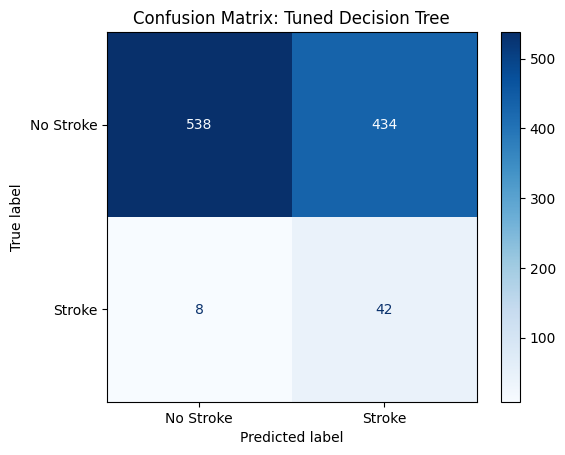

<Figure size 800x600 with 0 Axes>

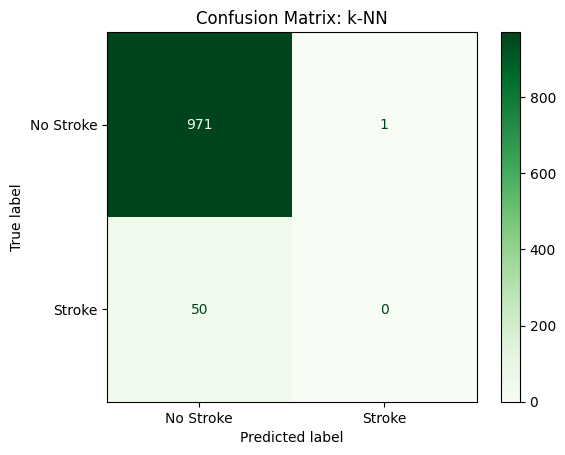

In [11]:

from sklearn.metrics import ConfusionMatrixDisplay

# Plot Confusion Matrix for the Tuned Decision Tree
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(best_dt_model, X_test, y_test, cmap='Blues', display_labels=['No Stroke', 'Stroke'])
plt.title('Confusion Matrix: Tuned Decision Tree')
plt.show()

# Plot Confusion Matrix for k-NN
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(knn_pipeline, X_test, y_test, cmap='Greens', display_labels=['No Stroke', 'Stroke'])
plt.title('Confusion Matrix: k-NN')
plt.show()

# Decision Tree Visualization

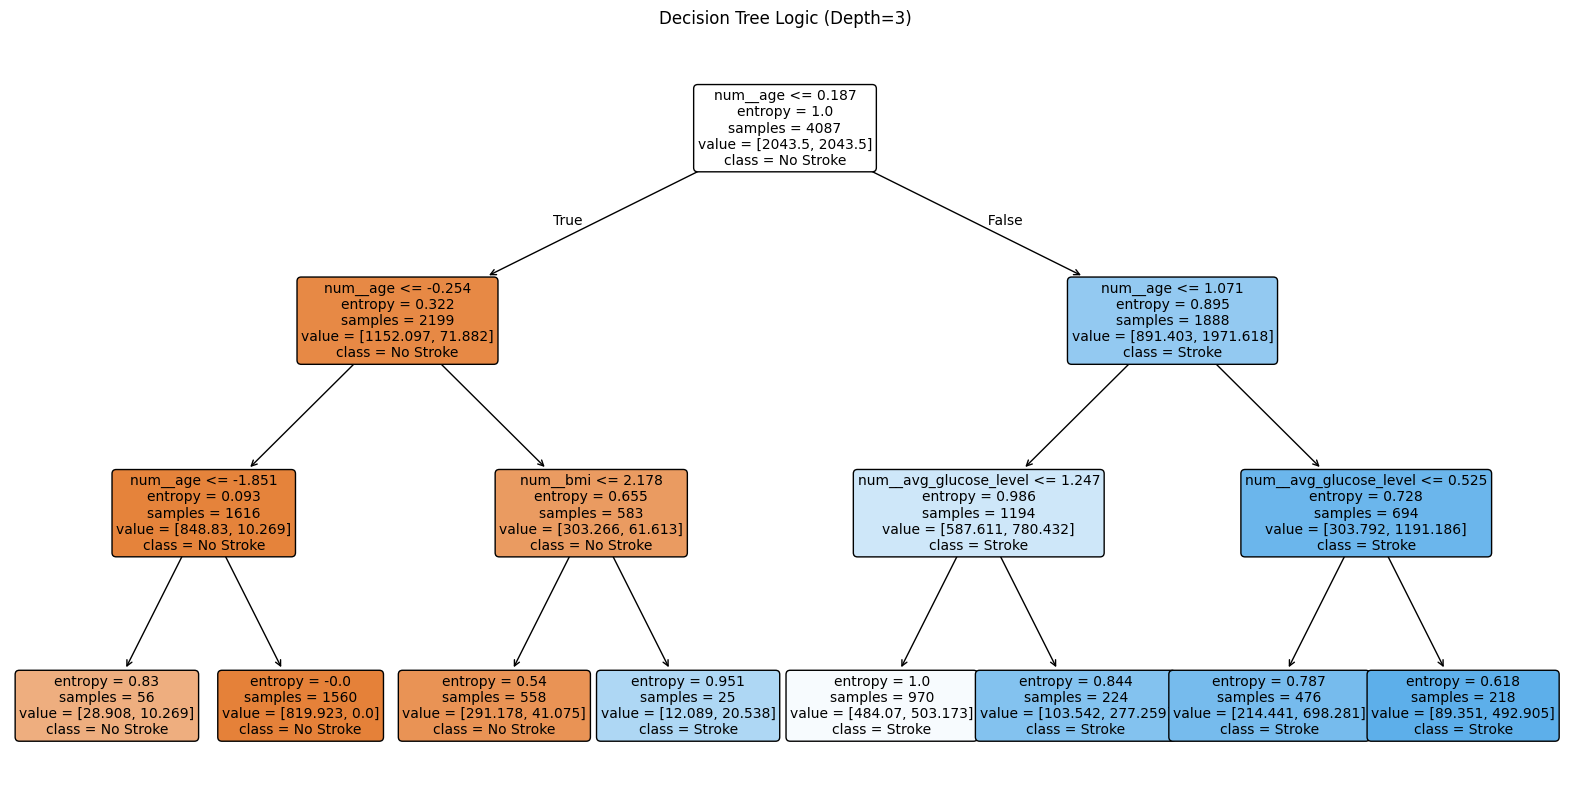

In [12]:

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

#Get the fitted preprocessor from the pipeline
fitted_preprocessor = best_dt_model.named_steps['preprocessor']

#Get the feature names
feature_names = fitted_preprocessor.get_feature_names_out()

#Plot
plt.figure(figsize=(20, 10))
plot_tree(best_dt_model.named_steps['classifier'], 
          feature_names=feature_names,
          class_names=['No Stroke', 'Stroke'],
          filled=True, 
          rounded=True, 
          fontsize=10)
plt.title("Decision Tree Logic (Depth=3)")
plt.show()

# Clustering K-Means

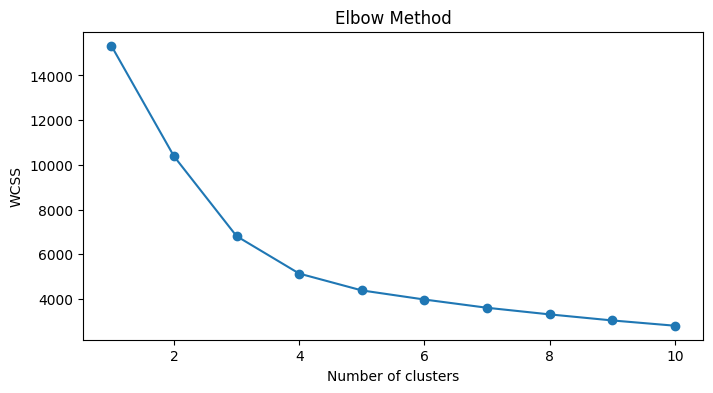

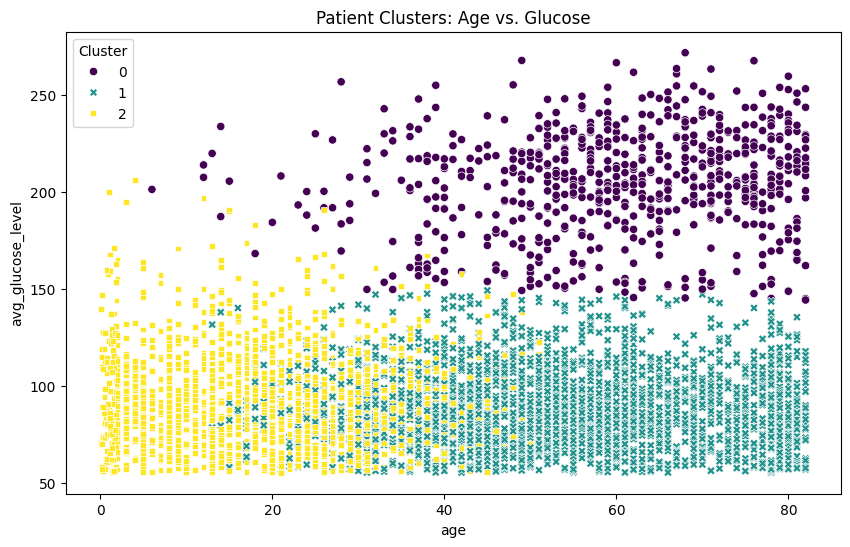


--- Cluster Profiles (Mean Values) ---
               age  avg_glucose_level        bmi
Cluster                                         
0        60.427754         205.193662  32.894421
1        54.329732          88.995060  31.676379
2        19.004635          92.687248  22.856315

--- Stroke Rate per Cluster ---
Cluster
0    0.130186
1    0.057377
2    0.002317
Name: Stroke_Actual, dtype: float64


In [13]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

cluster_cols = ['age', 'avg_glucose_level', 'bmi']
X_cluster = df[cluster_cols].copy()

# Handle missing BMI
X_cluster = X_cluster.fillna(X_cluster.median())

# Scale the data 
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Apply K-Means with K=3 
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_cluster_scaled)

# Add Cluster labels to the data for analysis
X_cluster['Cluster'] = clusters
X_cluster['Stroke_Actual'] = df['stroke'] 

# Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=X_cluster, x='age', y='avg_glucose_level', hue='Cluster', palette='viridis', style='Cluster')
plt.title('Patient Clusters: Age vs. Glucose')
plt.show()

print("\n--- Cluster Profiles (Mean Values) ---")
print(X_cluster.groupby('Cluster')[cluster_cols].mean())

print("\n--- Stroke Rate per Cluster ---")
print(X_cluster.groupby('Cluster')['Stroke_Actual'].mean())

# Association Rule Mining

In [14]:
from mlxtend.frequent_patterns import apriori, association_rules

basket = df[['gender', 'hypertension', 'heart_disease', 'smoking_status', 'stroke']].copy()

# Bin Numerical Features
basket['age_group'] = pd.cut(df['age'], bins=[0, 30, 55, 100], labels=['Young', 'Middle-Aged', 'Senior'])
basket['glucose_level'] = pd.cut(df['avg_glucose_level'], bins=[0, 100, 140, 300], labels=['Normal', 'Prediabetic', 'Diabetic'])
basket['bmi_cat'] = pd.cut(df['bmi'], bins=[0, 18.5, 25, 30, 100], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# Convert all to string
basket = basket.astype(str)

# One-Hot Encoding
basket_encoded = pd.get_dummies(basket)

# Apply Apriori
frequent_itemsets = apriori(basket_encoded, min_support=0.01, use_colnames=True)

# Generate Rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

# Filter for rules predicting Stroke
stroke_rules = rules[rules['consequents'].apply(lambda x: 'stroke_1' in x)]

print("\n--- Top Rules Predicting Stroke (Sorted by Lift) ---")
display(stroke_rules[['antecedents', 'consequents', 'lift', 'confidence', 'support']].sort_values('lift', ascending=False).head(10))


--- Top Rules Predicting Stroke (Sorted by Lift) ---


,antecedents,consequents,lift,confidence,support
842,"(age_group_Senior, glucose_level_Diabetic)",(stroke_1),3.620836,0.176471,0.016442
3538,"(age_group_Senior, hypertension_0, glucose_lev...",(stroke_1),3.510467,0.171091,0.011353
452,"(age_group_Senior, hypertension_1)",(stroke_1),3.449941,0.168142,0.011157
3542,"(age_group_Senior, glucose_level_Diabetic)","(hypertension_0, stroke_1)",3.401777,0.121849,0.011353
4486,"(age_group_Senior, heart_disease_0, glucose_le...",(stroke_1),3.173462,0.154667,0.011353
4490,"(age_group_Senior, glucose_level_Diabetic)","(heart_disease_0, stroke_1)",3.081808,0.121849,0.011353
3569,"(age_group_Senior, bmi_cat_Overweight)","(hypertension_0, stroke_1)",2.986773,0.106984,0.014093
856,"(age_group_Senior, bmi_cat_Overweight)",(stroke_1),2.957285,0.144131,0.018986
12918,"(age_group_Senior, bmi_cat_Overweight)","(heart_disease_0, hypertension_0, stroke_1)",2.955035,0.086181,0.011353
4518,"(age_group_Senior, bmi_cat_Overweight)","(heart_disease_0, stroke_1)",2.893745,0.114413,0.015071


# Insight on how these patterns can be implemented in Real World context
 
- The association rules identify groups of health characteristics such as age group, hypertension, smoker status, glucose levels that are linked to a patient's risk of stroke.
 
- Using this information, healthcare providers can identify at an early stage patients that have a high risk of stroke and provide them with close monitoring and preventative treatment options.
 
- Healthcare providers can develop specific intervention plans to address identified high risk populations based upon their health profile.
 
- Association rule knowledge base can be incorporated into clinical decision support systems to assist clinicians in identifying potential patient risks when multiple health factors exist simultaneously.
 
- Public health organizations can use this pattern data to inform population based education, awareness campaigns and prevention initiatives.